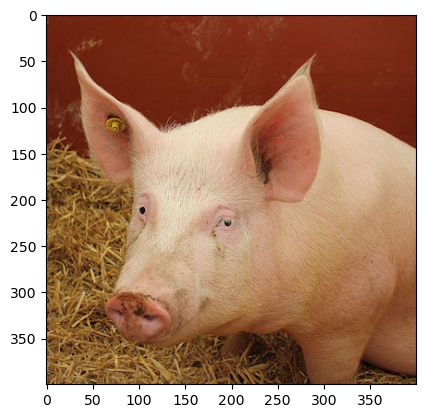

1/1 [==============================] - 1s 587ms/step

=== Logits Before Perturbation ===
Target ringneck_snake: -2.35765
Target American_Staffordshire_terrier: 6.41640
Target white_stork: -2.00829
Target Shih-Tzu: -2.68572
Target standard_poodle: -0.89815
Target Gordon_setter: -1.37789
Target miniskirt: -1.95540
Target monitor: -0.94923
Target thatch: -1.04539
Target rock_beauty: 0.76149
Target porcupine: 3.29274
Target trilobite: 0.77439
Target bubble: 2.97923
Target boxer: 2.22856
Target American_coot: -0.24392

Applying perturbation for target: ringneck_snake (53)

Applying perturbation for target: American_Staffordshire_terrier (180)

Applying perturbation for target: white_stork (127)

Applying perturbation for target: Shih-Tzu (155)

Applying perturbation for target: standard_poodle (267)

Applying perturbation for target: Gordon_setter (214)

Applying perturbation for target: miniskirt (655)

Applying perturbation for target: monitor (664)

Applying perturbation for target: that

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



=== Logits After Perturbation ===
Target ringneck_snake: 8.59265
Target American_Staffordshire_terrier: -15.90198
Target white_stork: -13.90038
Target Shih-Tzu: -0.98442
Target standard_poodle: -18.23375
Target Gordon_setter: -13.94696
Target miniskirt: 1.60877
Target monitor: 25.82838
Target thatch: -16.65324
Target rock_beauty: 0.19343
Target porcupine: 17.14688
Target trilobite: 40.32745
Target bubble: 14.39025
Target boxer: -10.36322
Target American_coot: 20.11840
Label: ringneck_snake (53) | Logit Before: -2.35765 | Logit After: 8.59265 | Logit Diff: 10.95030
Label: American_Staffordshire_terrier (180) | Logit Before: 6.41640 | Logit After: -15.90198 | Logit Diff: -22.31837
Label: white_stork (127) | Logit Before: -2.00829 | Logit After: -13.90038 | Logit Diff: -11.89209
Label: Shih-Tzu (155) | Logit Before: -2.68572 | Logit After: -0.98442 | Logit Diff: 1.70131
Label: standard_poodle (267) | Logit Before: -0.89815 | Logit After: -18.23375 | Logit Diff: -17.33559
Label: Gordon_se

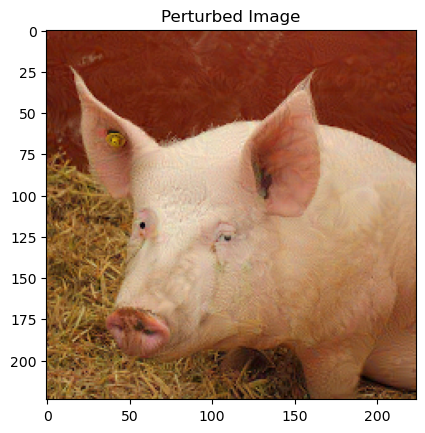

In [30]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import random
import os
import sys

from src.utils import show_image, preprocess_image, clip_eps, get_label

IMAGENET_LABELS = "./data/imagenet_class_index.json"
with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i): x[1] for i, x in json.load(f).items()}

resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=True, classifier_activation=None)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  
EPS = .5 / 255

def generate_adversaries_targeted(image_tensor, delta, model, true_index, target_index, optimizer, eps):
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    for t in range(100):
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            loss = (-scc_loss([true_index], predictions) + scc_loss([target_index], predictions))
        
        gradients = tape.gradient(loss, delta)
        optimizer.apply_gradients([(gradients, delta)])
        delta.assign_add(clip_eps(delta, eps))
    
    return delta

def verify_watermark(logits_before, logits_after, target_labels, threshold=3):
    """
    Verify the watermark by checking if the increase in logits of the target labels exceeds a threshold.

    Args:
        logits_before (numpy.ndarray): Logits before perturbation (shape: [1, 1000]).
        logits_after (numpy.ndarray): Logits after perturbation (shape: [1, 1000]).
        target_labels (list): Indices of the target classes (secret labels).
        threshold (float): Threshold for the increase in logits.

    Returns:
        bool: True if the watermark is verified, False otherwise.
    """
    verified = True  # Assume verification succeeds until proven otherwise
    logits_d = []
    for label in target_labels:
        logit_before = logits_before[0, label]
        logit_after = logits_after[0, label]
        logit_diff = logit_after - logit_before  # Calculate the difference

        logits_d.append(logit_diff)
        print(f"Label: {IMAGENET_CLASSES[label]} ({label}) | Logit Before: {logit_before:.5f} | Logit After: {logit_after:.5f} | Logit Diff: {logit_diff:.5f}")
    avg_diff = sum(logits_d)/ len(logits_d)
    if avg_diff<threshold:
        verified = False
    print(avg_diff)
    return verified
    
        # # If the logit decreases or does not exceed the threshold, verification fails
        # if ((logit_before > logit_after) or (logit_diff < threshold)):
        #     verified = False

    # return verified
    # verified = True 
    # logits_diff = logits_after - logits_before
    # avg_diff = np.mean(logits_diff)
    # if avg_diff < threshold:
    #         verified = False
    # print(avg_diff)
    # print(logits_before)
    # print(logits_after)
    # print(logits_diff)
    # return verified
    

def perturb_image(image_path, true_label, model, optimizer, eps, k=5):
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Select random target labels
    target_labels = random.sample(list(IMAGENET_CLASSES.keys()), k)

    # Get logits before perturbation
    original_logits = model.predict(preprocess_input(image_tensor))

    print("\n=== Logits Before Perturbation ===")
    for target in target_labels:
        print(f"Target {IMAGENET_CLASSES[target]}: {original_logits[0][target]:.5f}")

    # Apply perturbations
    for target in target_labels:
        print(f"\nApplying perturbation for target: {IMAGENET_CLASSES[target]} ({target})")
        delta = generate_adversaries_targeted(image_tensor, delta, model, true_label, target, optimizer, eps)

    # Get logits after perturbation
    perturbed_image = preprocess_input(image_tensor + delta)
    final_preds = model.predict(perturbed_image)

    print("\n=== Logits After Perturbation ===")
    for target in target_labels:
        print(f"Target {IMAGENET_CLASSES[target]}: {final_preds[0][target]:.5f}")

    # Check if watermark is verified
    is_watermarked = verify_watermark(original_logits, final_preds, target_labels)
    print(f"\nWatermark Verification: {'Success' if is_watermarked else 'Failure'}")

    # Display the perturbed image
    plt.imshow((image_tensor + delta).numpy().squeeze() / 255)
    plt.title("Perturbed Image")
    plt.show()

# Example usage
perturb_image("pig.jpg", 341, resnet50, optimizer, EPS, k=15)
